In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

df = pd.read_csv("listings.csv")
#print(df.head())

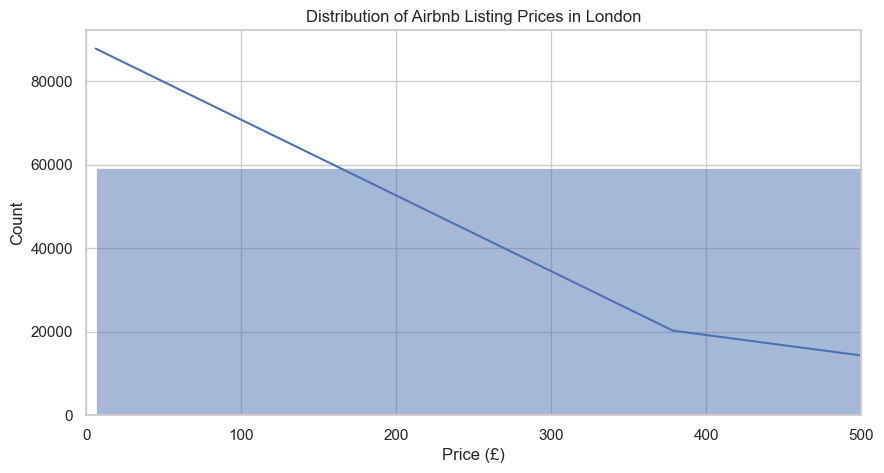

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=100, kde=True)
plt.xlim(0, 500)
plt.title("Distribution of Airbnb Listing Prices in London")
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.show()

In [ ]:
#Price Prediction (Using Regression) based on property attributes to predict a price

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
df = pd.read_csv("listings.csv")

#only rows with prices < 500 for cleaner learning - Eliminates Outliers
df = df[df["price"] < 500]

#drop rows with missing values in required columns
df = df.dropna(subset=["room_type", "minimum_nights", "number_of_reviews", "availability_365", "price"])
# Convert room type into numeric categories
df["room_type_encoded"] = df["room_type"].astype("category").cat.codes
# Features (X) and Target (y)
X = df[["room_type_encoded", "minimum_nights", "number_of_reviews", "availability_365"]]
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [15]:
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 6941.08
R² Score: 0.18


In [ ]:
#The re